In [1]:
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg

In [2]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
    sqrtoutputsize = int(np.sqrt(outputsize))
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def NonlinearPoisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    h = 1/(sqrtinputsize-1)
    KX = np.zeros([inputsize,inputsize+1])
    KY = np.zeros([inputsize+1,inputsize])
    for i in range(sqrtinputsize):
        for j in range(sqrtinputsize+1):
            KX[i][j] = a(j*h-0.5*h,i*h)
    for i in range(sqrtinputsize+1):
        for j in range(sqrtinputsize):
            KY[i][j] = a(j*h,i*h-0.5*h)
    OUTPUT = (gallery.nonlinearPoisson((sqrtinputsize,sqrtinputsize),KX,KY)).to_full()
    return OUTPUT

In [3]:
def Multigrid_circle(inputsize, A_A, B, R_A, s, w, NUM_EPOCH):
    A = np.matrix(A_A)
    P = 4*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    for i in range(NUM_EPOCH):
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

In [4]:
def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def rhoAuto(INPUT):
    R = INPUT[0]
    w = INPUT[1]
    P = 4*np.transpose(R)
    M = (w**(-1)) * np.diag(np.diag(A1))
    K = M - A1
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A1),P))),R),A1)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

In [19]:
def optimizer_GD(inputsize, A, R, w, s, learning_rate):
    rhoold = rho(inputsize,A,4*np.transpose(R),R,w,s)
    INPUT = [R,w]
    rhoGra = grad(rhoAuto)
    delta = rhoGra(INPUT)
    R -= learning_rate*delta[0]
    w -= learning_rate*delta[1]
    rhonew = rho(inputsize,A,4*np.transpose(R),R,w,s)
    return R, w, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate)
        R = Rnew
        w = wnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            M = M+L*A0-L*A1
            L = L-step_length
            step_length = step_length*0.1
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length and Restart!!')
            print("step_length = {}".format(step_length))      
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            P = 4*np.transpose(R)
            w = 2/3
        else:
            R = Rnew
            w = wnew
            L += step_length
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    Rhonew = rhonew
    return R, w, Rhoold, Rhonew, Radius

In [6]:
finegridsize = 5
s = 1
w = 2/3
MAX_ITER = 50

In [7]:
e = 0.01
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.cos((x + y)/e) + 2) + (3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*np.sin((x + y)/e))/e + (5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*np.sin((x + y)/e))/e
def a(x, y): return 2+np.cos((x+y)/e)

In [8]:
inputsize = (2**finegridsize-1)**2
inputsize = int(inputsize)
sqrtinputsize = int(np.sqrt(inputsize))
outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
sqrtoutputsize = int(np.sqrt(outputsize))
h = 1/(sqrtinputsize-1)
A0 = Poisson(inputsize)
A1 = NonlinearPoisson(inputsize)
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
R = Restriction(inputsize)
P = 4*np.transpose(R)

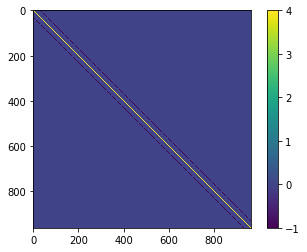

In [9]:
plt.imshow(A0)
plt.colorbar()

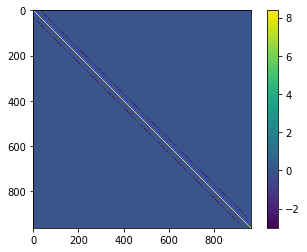

In [10]:
plt.imshow(A1)
plt.colorbar()

In [11]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1, RightF, R, s, w, MAX_ITER)

Residual = 11.25248519787601
Interation = 0
Residual = 1.9617626890783948
Interation = 1
Residual = 0.481898145299486
Interation = 2
Residual = 0.1370462020012952
Interation = 3
Residual = 0.04380519438321566
Interation = 4
Residual = 0.015272302950418357
Interation = 5
Residual = 0.005665748378214013
Interation = 6
Residual = 0.0021996236648069824
Interation = 7
Residual = 0.0008839252599224659
Interation = 8
Residual = 0.000364814909429661
Interation = 9
Residual = 0.0001537252708300438
Interation = 10
Residual = 6.583186484620383e-05
Interation = 11
Residual = 2.854994964041852e-05
Interation = 12
Residual = 1.2504891295738845e-05
Interation = 13
Residual = 5.52044044180712e-06
Interation = 14
Residual = 2.4525545425385153e-06
Interation = 15
Residual = 1.0952405164846256e-06
Interation = 16
Residual = 4.912035445703087e-07
Interation = 17
Residual = 2.2109503542570839e-07
Interation = 18
Residual = 9.98233938173324e-08
Interation = 19
Residual = 4.5189858547908686e-08
Interation = 

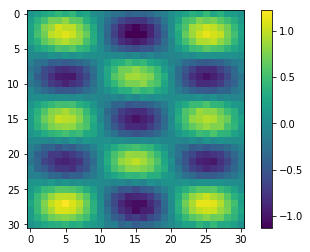

In [12]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Text(0, 0.5, 'Residual')

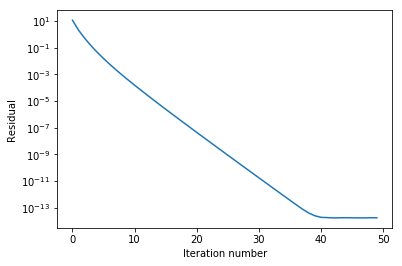

In [32]:
plt.semilogy(GMM_Res)
plt.xlabel('Iteration number')
plt.ylabel('Residual')

In [14]:
GMM_Radius = rho(inputsize,A1,4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.48948093396927367


In [20]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1, Restriction(inputsize),  2/3, s, learning_rate = 1e-1,accept_radius = GMM_Radius,step_length = 1e-1)

L = 0.2
rho = 0.4129292618384779
Decrease the step_length and Restart!!
step_length = 0.010000000000000002
rhonew = 0.9918392528690576
L = 0.11000000000000001
rho = 0.4503517016840938
L = 0.12000000000000002
rho = 0.445884187379227
L = 0.13000000000000003
rho = 0.4415357658977588
L = 0.14000000000000004
rho = 0.4371913321654181
L = 0.15000000000000005
rho = 0.4330904991487503
L = 0.16000000000000006
rho = 0.42953373616014306
L = 0.17000000000000007
rho = 0.4398763518226052
Decrease the step_length and Restart!!
step_length = 0.0010000000000000002
rhonew = 0.6970567490320132
L = 0.16100000000000006
rho = 0.45576406750730464
L = 0.16200000000000006
rho = 0.4553201155478963
L = 0.16300000000000006
rho = 0.4548769003914106
L = 0.16400000000000006
rho = 0.4544343235731692
L = 0.16500000000000006
rho = 0.45399233430496067
L = 0.16600000000000006
rho = 0.45355090859159636
L = 0.16700000000000007
rho = 0.45311003708422093
L = 0.16800000000000007
rho = 0.4526697180808428
L = 0.16900000000000007

L = 0.26900000000000013
rho = 0.41107164801466756
L = 0.27000000000000013
rho = 0.4106873310205193
L = 0.27100000000000013
rho = 0.4103035782997486
L = 0.27200000000000013
rho = 0.4099203993182937
L = 0.27300000000000013
rho = 0.4095378053661454
L = 0.27400000000000013
rho = 0.40915580983216665
L = 0.27500000000000013
rho = 0.4087744284952708
L = 0.27600000000000013
rho = 0.40839367982088154
L = 0.27700000000000014
rho = 0.4080135852454269
L = 0.27800000000000014
rho = 0.4076341694239857
L = 0.27900000000000014
rho = 0.4072554604074632
L = 0.28000000000000014
rho = 0.40687748970671633
L = 0.28100000000000014
rho = 0.4065002921935484
L = 0.28200000000000014
rho = 0.40612390578501295
L = 0.28300000000000014
rho = 0.40574837086142146
L = 0.28400000000000014
rho = 0.4053737293835527
L = 0.28500000000000014
rho = 0.4050000237037365
L = 0.28600000000000014
rho = 0.4046272951091467
L = 0.28700000000000014
rho = 0.4042555821897696
L = 0.28800000000000014
rho = 0.40388491917855424
L = 0.2890000

L = 0.38800000000000023
rho = 0.3802682089787133
L = 0.38900000000000023
rho = 0.38019967022896356
L = 0.39000000000000024
rho = 0.3801328983520441
L = 0.39100000000000024
rho = 0.380067853963746
L = 0.39200000000000024
rho = 0.3800044989286259
L = 0.39300000000000024
rho = 0.37994279638447465
L = 0.39400000000000024
rho = 0.3798827107658879
L = 0.39500000000000024
rho = 0.3798242078250644
L = 0.39600000000000024
rho = 0.3797672546485387
L = 0.39700000000000024
rho = 0.3797118196690593
L = 0.39800000000000024
rho = 0.3796578726722232
L = 0.39900000000000024
rho = 0.3796053847977863
L = 0.40000000000000024
rho = 0.3795543285358031
L = 0.40100000000000025
rho = 0.3795046777179033
L = 0.40200000000000025
rho = 0.37945640750412324
L = 0.40300000000000025
rho = 0.37940949436576776
L = 0.40400000000000025
rho = 0.3793639160648058
L = 0.40500000000000025
rho = 0.3793196516303089
L = 0.40600000000000025
rho = 0.3792766813324309
L = 0.40700000000000025
rho = 0.37923498665440586
L = 0.4080000000

L = 0.5080000000000003
rho = 0.3810889596401599
L = 0.5090000000000003
rho = 0.3811633488162185
L = 0.5100000000000003
rho = 0.38123843797919726
L = 0.5110000000000003
rho = 0.38131420460505017
L = 0.5120000000000003
rho = 0.38139062582079825
L = 0.5130000000000003
rho = 0.38146767840653834
L = 0.5140000000000003
rho = 0.3815453387982542
L = 0.5150000000000003
rho = 0.3816235830915099
L = 0.5160000000000003
rho = 0.3817023870460962
L = 0.5170000000000003
rho = 0.3817817260917018
L = 0.5180000000000003
rho = 0.38186157533465337
L = 0.5190000000000003
rho = 0.3819419095657684
L = 0.5200000000000004
rho = 0.3820227032693586
L = 0.5210000000000004
rho = 0.38210393063340026
L = 0.5220000000000004
rho = 0.38218556556089067
L = 0.5230000000000004
rho = 0.3822675816823904
L = 0.5240000000000004
rho = 0.3823499523697543
L = 0.5250000000000004
rho = 0.3824326507510375
L = 0.5260000000000004
rho = 0.38251564972656094
L = 0.5270000000000004
rho = 0.3825989219861144
L = 0.5280000000000004
rho = 0.3

L = 0.6280000000000004
rho = 0.38876190344741546
L = 0.6290000000000004
rho = 0.38878816873900135
L = 0.6300000000000004
rho = 0.3888139141382673
L = 0.6310000000000004
rho = 0.3888391487378085
L = 0.6320000000000005
rho = 0.3888638815300363
L = 0.6330000000000005
rho = 0.38888812140384593
L = 0.6340000000000005
rho = 0.3889118771418087
L = 0.6350000000000005
rho = 0.38893515741784807
L = 0.6360000000000005
rho = 0.388957970795383
L = 0.6370000000000005
rho = 0.38898032572590313
L = 0.6380000000000005
rho = 0.3890022305479469
L = 0.6390000000000005
rho = 0.38902369348645643
L = 0.6400000000000005
rho = 0.38904472265248485
L = 0.6410000000000005
rho = 0.38906532604322436
L = 0.6420000000000005
rho = 0.389085511542329
L = 0.6430000000000005
rho = 0.3891052869205112
L = 0.6440000000000005
rho = 0.38912465983638034
L = 0.6450000000000005
rho = 0.38914363783750744
L = 0.6460000000000005
rho = 0.3891622283616899
L = 0.6470000000000005
rho = 0.3891804387383885
L = 0.6480000000000005
rho = 0.3

L = 0.7480000000000006
rho = 0.3900285788742779
L = 0.7490000000000006
rho = 0.3900345691500692
L = 0.7500000000000006
rho = 0.390040624550166
L = 0.7510000000000006
rho = 0.3900467474663235
L = 0.7520000000000006
rho = 0.3900529402567422
L = 0.7530000000000006
rho = 0.390059205246097
L = 0.7540000000000006
rho = 0.3900655447255738
L = 0.7550000000000006
rho = 0.39007196095290775
L = 0.7560000000000006
rho = 0.39007845615242676
L = 0.7570000000000006
rho = 0.3900850325151017
L = 0.7580000000000006
rho = 0.39009169219859824
L = 0.7590000000000006
rho = 0.3900984373273348
L = 0.7600000000000006
rho = 0.39010526999254536
L = 0.7610000000000006
rho = 0.3901121922523459
L = 0.7620000000000006
rho = 0.3901192061318066
L = 0.7630000000000006
rho = 0.3901263136230276
L = 0.7640000000000006
rho = 0.39013351668521973
L = 0.7650000000000006
rho = 0.3901408172447917
L = 0.7660000000000006
rho = 0.39014821719543674
L = 0.7670000000000006
rho = 0.3901557183982312
L = 0.7680000000000006
rho = 0.39016

L = 0.8680000000000007
rho = 0.39162979448645735
L = 0.8690000000000007
rho = 0.39165228966135773
L = 0.8700000000000007
rho = 0.3916749382243034
L = 0.8710000000000007
rho = 0.39169773977081573
L = 0.8720000000000007
rho = 0.3917206938881383
L = 0.8730000000000007
rho = 0.3917438001553918
L = 0.8740000000000007
rho = 0.391767058143927
L = 0.8750000000000007
rho = 0.39179046741743584
L = 0.8760000000000007
rho = 0.3918140275323507
L = 0.8770000000000007
rho = 0.39183773803789296
L = 0.8780000000000007
rho = 0.39186159847653923
L = 0.8790000000000007
rho = 0.39188560838398023
L = 0.8800000000000007
rho = 0.3919097672896878
L = 0.8810000000000007
rho = 0.3919340747167431
L = 0.8820000000000007
rho = 0.39195853018255494
L = 0.8830000000000007
rho = 0.39198313319849415
L = 0.8840000000000007
rho = 0.39200788327084063
L = 0.8850000000000007
rho = 0.3920327799001265
L = 0.8860000000000007
rho = 0.392057822582436
L = 0.8870000000000007
rho = 0.3920830108083017
L = 0.8880000000000007
rho = 0.3

L = 0.9880000000000008
rho = 0.4095957378070961
L = 0.9890000000000008
rho = 0.40927466208408003
L = 0.9900000000000008
rho = 0.4089545318559905
L = 0.9910000000000008
rho = 0.40863533548171943
L = 0.9920000000000008
rho = 0.4083170780106549
L = 0.9930000000000008
rho = 0.40799977390667114
L = 0.9940000000000008
rho = 0.4076834435275131
L = 0.9950000000000008
rho = 0.4073681113593373
L = 0.9960000000000008
rho = 0.40705380512285433
L = 0.9970000000000008
rho = 0.4067405553352306
L = 0.9980000000000008
rho = 0.40642839512176054
L = 0.9990000000000008
rho = 0.4061173601708247
L = 1.0000000000000007
rho = 0.4058074887750204


In [22]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1, RightF, Rnew, s, wnew, MAX_ITER)

Residual = 14.700646204111713
Interation = 0
Residual = 4.15512679380539
Interation = 1
Residual = 1.2489875155790577
Interation = 2
Residual = 0.38535810743744153
Interation = 3
Residual = 0.12072584508834704
Interation = 4
Residual = 0.03817350846415621
Interation = 5
Residual = 0.012144198471507902
Interation = 6
Residual = 0.003880537412649692
Interation = 7
Residual = 0.0012443766205003993
Interation = 8
Residual = 0.00040028170470927173
Interation = 9
Residual = 0.00012914278229573582
Interation = 10
Residual = 4.179099537494621e-05
Interation = 11
Residual = 1.3566972834640582e-05
Interation = 12
Residual = 4.419798636050334e-06
Interation = 13
Residual = 1.4455060046816063e-06
Interation = 14
Residual = 4.748505908736686e-07
Interation = 15
Residual = 1.5677396804850319e-07
Interation = 16
Residual = 5.2054938204044704e-08
Interation = 17
Residual = 1.7395268904859715e-08
Interation = 18
Residual = 5.854556154256455e-09
Interation = 19
Residual = 1.9858351293448434e-09
Interati

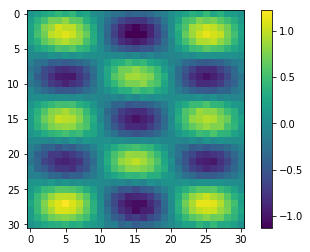

In [23]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Text(0, 0.5, 'Residual')

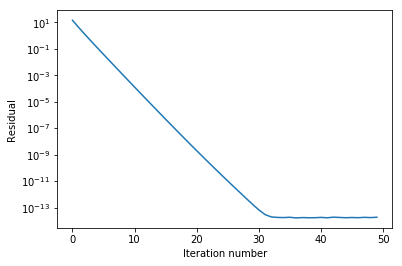

In [31]:
plt.semilogy(DMM_Res)
plt.xlabel('Iteration number')
plt.ylabel('Residual')

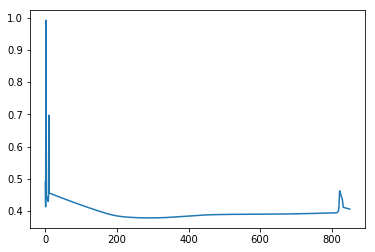

In [25]:
plt.plot(Radius)
plt.xlabel('Optimization step of DMM')
plt.ylabel('Spectral Radius')

In [26]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.4058074887750204


In [27]:
print('Omega after optimization = {}'.format(wnew))

Omega after optimization = 0.791257100763729


R under log10(abs())


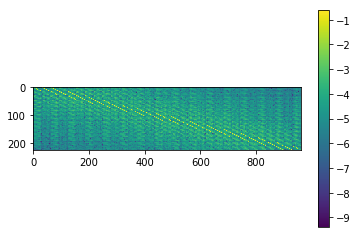

In [28]:
print("R under log10(abs())")
plt.imshow(np.log10(np.abs(Rnew)))
plt.colorbar()

One line of R under log10(abs())


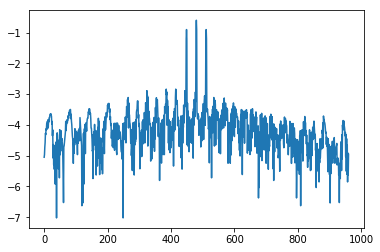

In [29]:
print("One line of R under log10(abs())")
plt.plot(np.log10(np.abs(Rnew))[round(0.5*outputsize)][:])

Text(0, 0.5, 'Spectral radius of matrix C')

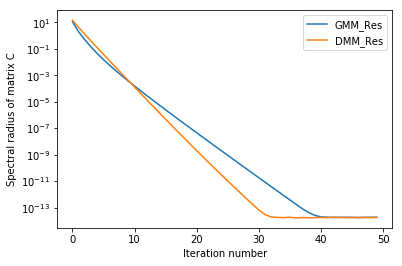

In [30]:
plt.semilogy(GMM_Res, label = 'GMM_Res')
plt.semilogy(DMM_Res, label = 'DMM_Res')
plt.legend(loc='upper right')
plt.xlabel('Iteration number')
plt.ylabel('Residual')